In [1]:
import sys
sys.path.append('../')
sys.path.append('../old/')

import matplotlib.pyplot as plt

import FiniteDifferences_ShortleyWeller_SquareGrid as PIC_FDSW
import FiniteDifferences_Staircase_SquareGrid as PIC_FD
import FFT_OpenBoundary_SquareGrid as PIC_FFT
import FFT_PEC_Boundary_SquareGrid as PIC_FFTPEC

import geom_impact_ellip as ell
from scipy import rand
import numpy as np

In [2]:
from pypic import PyPIC_Fortran_M2P_P2M, PyPIC
from meshing import RectMesh2D
from poisson_solver import FD_solver as FD
from poisson_solver import FFT_solver as FFT
from poisson_solver.FD_solver import laplacian_2D_5stencil

PyKLU not found


In [3]:
R_cham = 1e-1
R_charge = 4e-2
N_part_gen = 100000
Dh = 1e-3

from scipy.constants import e, epsilon_0

qe = e
eps0 = epsilon_0

chamber = ell.ellip_cham_geom_object(x_aper = R_cham, y_aper = R_cham)


#poissonsolver = FD.FiniteDifferences_ShortleyWeller_SquareGrid_extrapolation(chamb=chamber, Dh=Dh)
poissonsolver = FD.FiniteDifferences_ShortleyWeller_SquareGrid(chamb=chamber, Dh=Dh, ext_boundary=False)

poissonsolver_FFT = FFT.FFT_OpenBoundary_SquareGrid(x_aper=chamber.x_aper, y_aper=chamber.y_aper, Dh=Dh)
poissonsolver_FFT_PEC = FFT.FFT_PEC_Boundary_SquareGrid(x_aper=chamber.x_aper, y_aper=chamber.y_aper, Dh=Dh)

mesh = RectMesh2D(poissonsolver_FFT.bias_x,
                  poissonsolver_FFT.bias_y,
                  Dh, Dh,
                  poissonsolver_FFT.Nxg,
                  poissonsolver_FFT.Nyg)

print('mesh nx, ny: ' + str(mesh.nx) + ',' + str(mesh.ny))



#new_pp = PyPIC_Fortran_M2P_P2M(mesh, poissonsolver, gradient=poissonsolver.gradient)
new_pp = PyPIC(mesh, poissonsolver, gradient=poissonsolver.gradient)

new_pp_FFT = PyPIC_Fortran_M2P_P2M(mesh, poissonsolver_FFT)
new_pp_FFT_PEC = PyPIC_Fortran_M2P_P2M(mesh, poissonsolver_FFT_PEC)

picFFTPEC = PIC_FFTPEC.FFT_PEC_Boundary_SquareGrid(x_aper = chamber.x_aper, y_aper = chamber.y_aper, Dh = Dh, fftlib='pyfftw')
picFD = PIC_FD.FiniteDifferences_Staircase_SquareGrid(chamb = chamber, Dh = Dh)
picFDSW = PIC_FDSW.FiniteDifferences_ShortleyWeller_SquareGrid(chamb = chamber, Dh = Dh)
picFFT = PIC_FFT.FFT_OpenBoundary_SquareGrid(x_aper = chamber.x_aper, y_aper = chamber.y_aper, Dh = Dh, fftlib='pyfftw')


Nxg 201
Nyg 201
Mat. assembly 0%
Mat. assembly 5%
Mat. assembly 10%
Mat. assembly 15%
Mat. assembly 20%
Mat. assembly 25%
Mat. assembly 30%
Mat. assembly 35%
Mat. assembly 40%
Mat. assembly 45%
Mat. assembly 50%
Mat. assembly 55%
Mat. assembly 60%
Mat. assembly 65%
Mat. assembly 70%
Mat. assembly 75%
Mat. assembly 80%
Mat. assembly 85%
Mat. assembly 90%
Mat. assembly 95%
Mat. assembly 100%
Using scipy superlu solver...
Done PIC init.
201 201 0.001
Using PyFFTW
mesh nx, ny: 201,201
Start PIC init.:
FFT, PEC Boundary, Square Grid
PyPIC Version 1.02
Start PIC init.:
Finite Differences, Square Grid
PyPIC Version 1.02
Mat. assembly 0%
Mat. assembly 5%
Mat. assembly 10%
Mat. assembly 15%
Mat. assembly 20%
Mat. assembly 25%
Mat. assembly 30%
Mat. assembly 35%
Mat. assembly 40%
Mat. assembly 45%
Mat. assembly 50%
Mat. assembly 55%
Mat. assembly 60%
Mat. assembly 65%
Mat. assembly 70%
Mat. assembly 75%
Mat. assembly 80%
Mat. assembly 85%
Mat. assembly 90%
Mat. assembly 95%
Mat. assembly 100%
Us

In [4]:
def test_new_solver(new_solver, xx, yy, charge=e, x_probe=None, y_probe=None):
    '''
    Return rho, Phi, efx, efy, Ex, Ey
    '''
    mesh_charges = new_solver.particles_to_mesh(xx, yy, charge=charge)
    print 'rho: ' + str(mesh_charges.shape)
    rho = mesh_charges/new_solver.mesh.volume_elem
    phi = new_solver.poisson_solve(rho)
    print 'phi: ' + str(phi.shape)
    mesh_e_fields = new_solver.get_electric_fields(phi)
    efx = mesh_e_fields[0]
    efy = mesh_e_fields[1]
    print 'efx: ' + str(efx.shape)
#     for i, field in enumerate(mesh_e_fields):
#         print(field.flags)
#         mesh_e_fields[i] = np.ascontiguousarray(field.flatten())
    mesh_fields_and_mp_coords = zip(list(mesh_e_fields), [x_probe, y_probe])
    fields = new_solver.field_to_particles(*mesh_fields_and_mp_coords)
    Ex = fields[0]
    Ey = fields[1]
    return rho, phi, efx, efy, Ex, Ey


In [5]:
# generate particles
x_part = R_charge*(2.*rand(N_part_gen)-1.)
y_part = R_charge*(2.*rand(N_part_gen)-1.)
mask_keep  = x_part**2+y_part**2<R_charge**2
x_part = x_part[mask_keep]
y_part = y_part[mask_keep]

nel_part = 0*x_part+1.

#pic scatter
picFD.scatter(x_part, y_part, nel_part, charge=e)
picFDSW.scatter(x_part, y_part, nel_part, charge=e)
picFFT.scatter(x_part, y_part, nel_part, charge=e)
picFFTPEC.scatter(x_part, y_part, nel_part, charge=e)


#pic scatter
picFD.solve()
picFDSW.solve()
picFFT.solve()
picFFTPEC.solve()

    
x_probes = np.linspace(0,R_cham,1000)
y_probes = 0. * x_probes

    

rho_FFT, phi_FFT, efx_FFT, efy_FFT, Ex_FFT, Ey_FFT = test_new_solver(new_pp_FFT, xx=x_part, yy=y_part,
                                                                     charge=e,
                                                                     x_probe=x_probes, y_probe=y_probes)
#efx_FFT.reshape(efx_FFT.shape, order='F')

rho, phi, efx, efy, Ex, Ey = test_new_solver(new_pp, xx=x_part, yy=y_part,
                                             charge=e,
                                             x_probe=x_probes, y_probe=y_probes)

rho_FFT_PEC, phi_FFT_PEC, efx_FFT_PEC, efy_FFT_PEC, Ex_FFT_PEC, Ey_FFT_PEC = test_new_solver(new_pp_FFT_PEC,
                                                                                             xx=x_part,
                                                                                             yy=y_part,
                                                                                             charge=e,
                                                                                             x_probe=x_probes,
                                                                                             y_probe=y_probes)

#pic gather
Ex_FD, Ey_FD = picFD.gather(x_probes, y_probes)
Ex_FDSW, Ey_FDSW = picFDSW.gather(x_probes, y_probes)
Ex_FFT_old, Ey_FFT_old = picFFT.gather(x_probes, y_probes)
Ex_FFT_PEC_old, Ey_FFT_PEC_old = picFFTPEC.gather(x_probes, y_probes)


E_r_th = map(lambda x: np.sum(x_part**2+y_part**2<x**2)*qe/eps0/(2*np.pi*x), x_probes)

rho: (201, 201)
Nyg, Nxg open fft 201 201
rho.shape (201, 201)
phi: (201, 201)
(201, 201)
efx: (201, 201)
rho: (201, 201)
phi: (201, 201)
(201, 201)
efx: (201, 201)
rho: (201, 201)
phi: (201, 201)
(201, 201)
efx: (201, 201)


/home/oeftiger/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:52: RuntimeWarning: invalid value encountered in double_scalars


(201, 201)


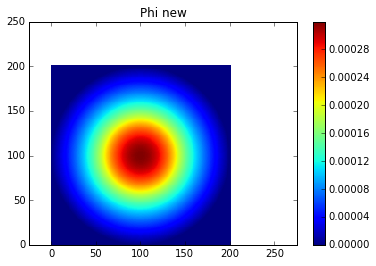

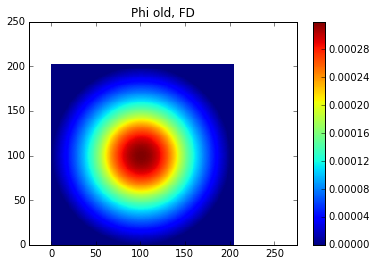

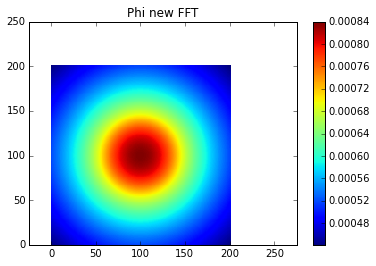

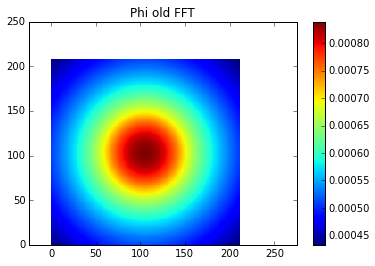

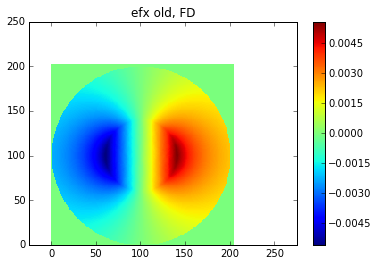

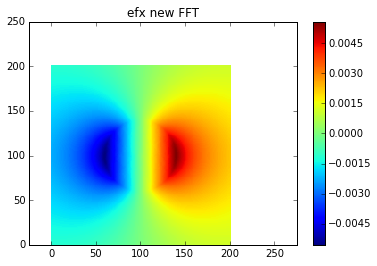

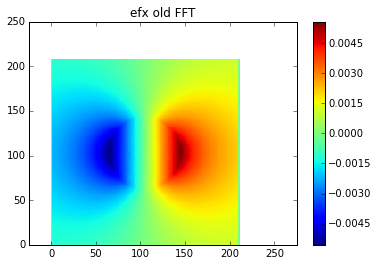

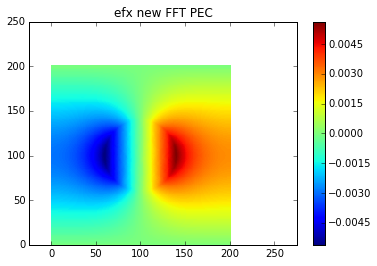

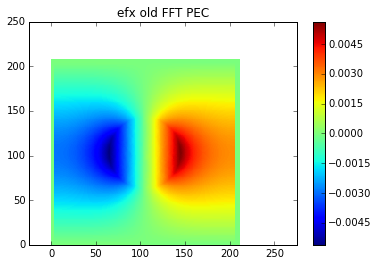

In [6]:
%matplotlib inline

print phi.shape
plt.figure()
plt.pcolor(phi)
plt.colorbar()
plt.axis('equal')
plt.title('Phi new')
plt.show()



plt.figure()
plt.pcolor(picFDSW.phi.T[3:-2,4:-3])
plt.colorbar()
plt.title('Phi old, FD')
plt.axis('equal')
plt.show()

plt.figure()
plt.pcolor(phi_FFT)
plt.colorbar()
plt.axis('equal')
plt.title('Phi new FFT')
plt.show()

plt.pcolor(picFFT.phi.T)
plt.colorbar()
plt.axis('equal')
plt.title('Phi old FFT')
plt.show()

plt.figure()
plt.pcolor(picFDSW.efx.T[3:-2,4:-3])
plt.colorbar()
plt.title('efx old, FD')
plt.axis('equal')
plt.show()

plt.figure()
plt.pcolor(efx_FFT)
plt.colorbar()
plt.axis('equal')
plt.title('efx new FFT')
plt.show()

plt.pcolor(picFFT.efx.T)
plt.colorbar()
plt.axis('equal')
plt.title('efx old FFT')
plt.show()



plt.figure()
plt.pcolor(efx_FFT_PEC)
plt.colorbar()
plt.axis('equal')
plt.title('efx new FFT PEC')
plt.show()

plt.pcolor(picFFTPEC.efx.T)
plt.colorbar()
plt.axis('equal')
plt.title('efx old FFT PEC')
plt.show()

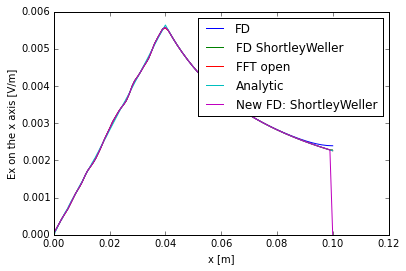

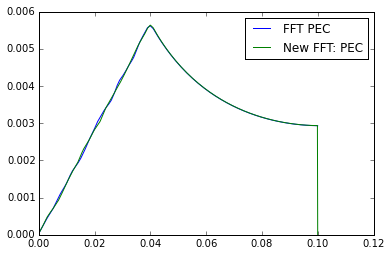

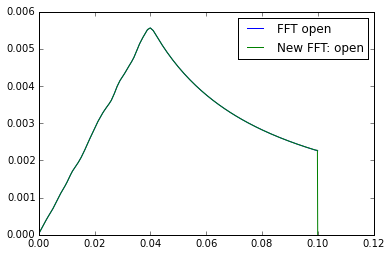

In [7]:
plt.close('all')
plt.plot(x_probes, Ex_FD, label = 'FD')
plt.plot(x_probes, Ex_FDSW, label = 'FD ShortleyWeller')
plt.plot(x_probes, Ex_FFT_old, label = 'FFT open')
plt.plot(x_probes, E_r_th, label = 'Analytic')
plt.plot(x_probes, Ex, label = 'New FD: ShortleyWeller')

#pl.plot(picFFT.xg, picFFT.efx[picFFT.ny/2, :])
plt.legend()
plt.ylabel('Ex on the x axis [V/m]')
plt.xlabel('x [m]')

plt.show()

plt.plot(x_probes, Ex_FFT_PEC_old, label = 'FFT PEC')
plt.plot(x_probes, Ey_FFT_PEC, label='New FFT: PEC')

plt.legend()
plt.show()

plt.plot(x_probes, Ex_FFT_old, label = 'FFT open')
plt.plot(x_probes, Ey_FFT, label='New FFT: open')

plt.legend()
plt.show()

In [8]:
phi_FFT.shape

(201, 201)

In [9]:
picFFT.phi.shape

(211, 207)